# Benchmark

This benchmark is based on [this article](https://www.depends-on-the-definition.com/identify-ingredients-with-neural-networks/) with some minor adaptations for the problem we are trying to solve.

In [1]:
try:
    already_initialized
except NameError:
    !python -m pip install --upgrade pip
    !pip install spacy==2.3.5
    !python -m spacy download de_core_news_sm
    !pip install tensorflow
    !pip install keras
    already_initialized = True

     |████████████████████████████████| 1.5 MB 16.3 MB/s eta 0:00:01
  Attempting uninstall: pip
    Found existing installation: pip 21.0.1
    Uninstalling pip-21.0.1:
      Successfully uninstalled pip-21.0.1
     |████████████████████████████████| 10.4 MB 17.3 MB/s eta 0:00:01
     |████████████████████████████████| 126 kB 72.5 MB/s eta 0:00:01
     |████████████████████████████████| 184 kB 71.0 MB/s eta 0:00:01
     |████████████████████████████████| 75 kB 6.8 MB/s  eta 0:00:01
     |████████████████████████████████| 9.8 MB 64.0 MB/s eta 0:00:01
     |████████████████████████████████| 1.1 MB 56.7 MB/s eta 0:00:01
     |████████████████████████████████| 14.9 MB 6.6 MB/s eta 0:00:01
  Created wheel for de-core-news-sm: filename=de_core_news_sm-2.3.0-py3-none-any.whl size=14907581 sha256=d3f14d85ea2f878e44a81a64d2d3b3d0eb116da4d81d31e19f3272bd41d2e7a0
  Stored in directory: /tmp/pip-ephem-wheel-cache-5lpvw1sb/wheels/fe/44/0f/7270b8ec13bc290e606a3c0f52f981915b1d09d1dfc7c79088
Successf

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



     |████████████████████████████████| 454.3 MB 11 kB/s s eta 0:00:01     |████████████████████████████▏   | 400.0 MB 69.5 MB/s eta 0:00:01     |██████████████████████████████▊ | 436.2 MB 70.1 MB/s eta 0:00:01
     |████████████████████████████████| 462 kB 50.7 MB/s eta 0:00:01
     |████████████████████████████████| 65 kB 5.8 MB/s  eta 0:00:01
     |████████████████████████████████| 1.2 MB 52.3 MB/s eta 0:00:01
     |████████████████████████████████| 42 kB 1.9 MB/s  eta 0:00:01
     |████████████████████████████████| 6.0 MB 52.5 MB/s eta 0:00:01
     |████████████████████████████████| 129 kB 77.6 MB/s eta 0:00:01
     |████████████████████████████████| 4.0 MB 47.9 MB/s eta 0:00:01
     |████████████████████████████████| 4.9 MB 48.7 MB/s eta 0:00:01
     |████████████████████████████████| 97 kB 10.5 MB/s eta 0:00:01
     |████████████████████████████████| 781 kB 50.6 MB/s eta 0:00:01
     |████████████████████████████████| 146 kB 78.2 MB/s eta 0:00:01
     |███████████████████████████

In [2]:
import numpy as np
import pandas as pd
import spacy
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.sequence import pad_sequences

print(tf.__version__)
print(tf.keras.__version__)

2.5.0
2.5.0


In [3]:
df = pd.read_json("data/recipes.json")
df.Instructions[2]

'Die Kirschen abtropfen lassen, dabei den Saft auffangen. Das Puddingpulver mit dem Vanillezucker mischen und mit 6 EL Saft glatt rühren. Den übrigen Kirschsaft aufkochen und vom Herd nehmen. Das angerührte Puddingpulver einrühren und unter Rühren ca. eine Minute köcheln. Die Kirschen unter den angedickten Saft geben. Milch, 40 g Zucker, Vanillemark und Butter aufkochen. Den Topf vom Herd ziehen und den Grieß unter Rühren einstreuen. Unter Rühren einmal aufkochen lassen und zugedeckt ca. fünf Minuten quellen lassen.In der Zeit das Ei trennen. Das Eiweiß mit einer Prise Salz steif schlagen und dabei die restlichen 20 g Zucker einrieseln lassen. Das Eigelb unter den Brei rühren und dann das Eiweiß unterheben.Den Grießbrei mit dem Kompott servieren.'

In [4]:
eval_df = df[11000:]
eval_df.shape

(1190, 8)

In [5]:
df = df[:11000]
df.shape

(11000, 8)

In [6]:
nlp = spacy.load('de_core_news_sm', disable=['parser', 'tagger', 'ner'])
tokenized = [nlp(t) for t in df.Instructions.values]
vocab = {"<UNK>": 1, "<PAD>": 0}
for txt in tokenized:
    for token in txt:
        if token.text not in vocab.keys():
            vocab[token.text] = len(vocab)
print("Number of unique tokens: {}".format(len(vocab)))

Number of unique tokens: 17556


In [7]:
ingredients = df.Ingredients
ingredients[0]

['600 g Hackfleisch, halb und halb',
 '800 g Sauerkraut',
 '200 g Wurst, geräucherte (Csabai Kolbász)',
 '150 g Speck, durchwachsener, geräucherter',
 '100 g Reis',
 '1 m.-große Zwiebel(n)',
 '1 Zehe/n Knoblauch',
 '2 Becher Schmand',
 '1/2TL Kümmel, ganzer',
 '2 Lorbeerblätter',
 'Salz und Pfeffer',
 '4 Ei(er) (bei Bedarf)',
 'Paprikapulver',
 'etwas Wasser',
 'Öl']

In [8]:
def _filter(token):
    if len(token) < 2:
        return False
    if token.is_stop:
        return False
    if token.text[0].islower():
        return False
    if token.is_digit:
        return False
    if token.like_num:
        return False
    return True

def _clean(text):
    text = text.replace("(", "")
    text = text.split("/")[0]
    return text

In [9]:
clean = [_clean(t.text) for i in ingredients[214] for t in nlp(i) if _filter(t) and len(_clean(t.text)) >= 2]
clean

['Rosenkohl',
 'Schalotte',
 '2Tasse',
 'Hühnerbrühe',
 'Milch',
 'EL',
 'Crème',
 'Speck',
 'Kartoffelgnocchi']

In [10]:
def get_labels(ingredients, tokenized_instructions):
    labels = []
    for ing, ti in zip(ingredients, tokenized_instructions):
        l_i = []
        ci = [_clean(t.text) for i in ing for t in nlp(i) if _filter(t) and len(_clean(t.text)) >= 2]
        label = []
        for token in ti:
            l_i.append(any((c == token.text or c == token.text[:-1] or c[:-1] == token.text) for c in ci))
        labels.append(l_i)
    return labels

In [11]:
labels = get_labels(ingredients, tokenized)
set([t.text for t, l in zip(tokenized[214], labels[214]) if l])

{'Crème', 'Hühnerbrühe', 'Milch', 'Rosenkohl', 'Schalotten', 'Speck'}

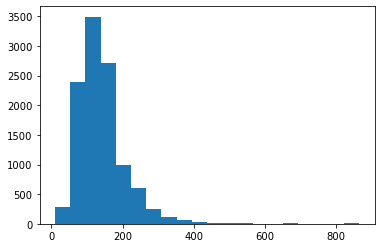

In [12]:
%matplotlib inline

plt.hist([len([t for t in tokens]) for tokens in tokenized], bins=20);

In [13]:
MAX_LEN = 400

In [14]:
def prepare_sequences(texts, max_len, vocab={"<UNK>": 1, "<PAD>": 0}):
    X = [[vocab.get(w.text, vocab["<UNK>"]) for w in s] for s in texts]
    return pad_sequences(maxlen=max_len, sequences=X, padding="post", value=vocab["<PAD>"])

In [15]:
X_seq = prepare_sequences(tokenized, max_len=MAX_LEN, vocab=vocab)
X_seq[1]

array([192, 193, 194, 183, 195, 196, 128, 197,   9, 198, 199, 200, 201,
       202, 203,  60, 204, 205,   9,  13, 206,  15,  23,  98, 207, 208,
        51, 209,  68, 202, 203,  25,   6, 195, 125, 202, 210, 211, 212,
        33,  45, 213, 214, 100, 196,  13, 215, 216, 217,  33,   9,  68,
       218, 219, 213, 169,  35,  82, 100, 220, 221, 202,   6, 222,  45,
       223,  48, 224,  33,  67, 225, 100, 226,   6, 227, 228, 229, 130,
        45,  92,  85, 230, 211, 231,   6, 232, 233, 234, 235, 145, 157,
       236,   9, 237, 238, 104, 239, 210, 240, 157, 241,  54,   6, 109,
       242, 243, 244, 245, 246, 187, 247,   6, 248, 183, 249, 250,  33,
       129,  13, 251, 252, 101, 253,  33, 254,   9,  31, 255,  40, 172,
         6,   2, 256, 257, 177, 258, 259, 260,  33,  42, 261, 262, 263,
       131, 264, 265, 266,  33, 267,  74, 268, 269,  68, 270,   6,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   

In [16]:
y_seq = []
for l in labels:
    y_i = []
    for i in range(MAX_LEN):
        try:
            y_i.append(float(l[i]))
        except:
            y_i.append(0.0)
    y_seq.append(np.array(y_i))
y_seq = np.array(y_seq)
y_seq = y_seq.reshape(y_seq.shape[0], y_seq.shape[1], 1)

# Setup the network

In [17]:
model = tf.keras.models.load_model('model/benchmark_model_2021-03-13_14-57-29_loss-0.02')

In [18]:
y_pred = model.predict(X_seq, verbose=1, batch_size=512)

22/22 [==============================] - 25s 936ms/step


In [19]:
i = 3343
pred_i = y_pred[i] > 0.05 # Predictions

In [20]:
tokenized[i] # Original text as a list of tokens

Kohlrabi schälen, waschen und in Stifte schneiden. Brühe und Milch ankochen, Kohlrabi dazugeben, aufkochen lassen und 10 Minuten kochen. Dann herausnehmen und abtropfen lassen, die Brühe aufheben.Butter erhitzen, das Mehl darin anschwitzen, mit Kohlrabibrühe ablöschen und aufkochen lassen. Mit den Gewürzen abschmecken. Kohlrabi wieder dazugeben.Hähnchenbrust schnetzeln, kräftig anbraten und würzen. Das Fleisch in eine Auflaufform geben, die Speckwürfel darüber verteilen. Mit Käse bestreuen. Nun das Gemüse darüber schichten und alles bei 180 °C ca. 25 Minuten überbacken.Tipp:Man kann auch gut gekochte, in Würfel geschnittene Kartoffeln unter die Kohlrabi mischen. Ebenso kann man auch Kohlrabi und Möhren für den Auflauf nehmen. Schmeckt auch sehr lecker!

In [21]:
ingreds = [t.text for t, p in zip(tokenized[i], pred_i) if p] # The list of tokens in the text with a prediction greater than 0.05
print(set(ingreds))

{'Brühe', 'Gemüse', 'Kartoffeln', 'Kohlrabi', 'Butter', 'Speckwürfel', 'Käse', 'Möhren', 'Milch', 'Mehl'}


In [22]:
ingreds = [t.text for t, p in zip(tokenized[i], y_seq[i]) if p] # The list of tokens in the text that were originally labeled as ingredients
set(ingreds)

{'Butter', 'Kohlrabi', 'Käse', 'Mehl', 'Milch'}

In [23]:
ingredients[i] # The actual list of ingredients used for labelling

['500 g Kohlrabi',
 '1/4Liter Hühnerbrühe',
 '1/4Liter Milch',
 '1 EL Butter',
 '30 g Mehl',
 '300 g Hähnchenbrustfilet(s)',
 'Salz und Pfeffer',
 'Muskat',
 '50 g Käse, gerieben',
 '50 g Speck, gewürfelt']

This looks very good! Our model seems to be able to identify the ingredients better than our training labels. So we now use the produced labels for fine-tuning the network.

In [24]:
new_labels = []
for pred_i, ti in zip(y_pred, tokenized):
    l_i = []
    ci = [t.text for t, p in zip(tokenized[i], pred_i > 0.05) if p]
    label = []
    for token in ti:
        l_i.append(any((c == token.text or c == token.text[:-1] or c[:-1] == token.text) for c in ci))
    new_labels.append(l_i)

In [25]:
y_seq_new = []
for l in new_labels:
    y_i = []
    for i in range(MAX_LEN):
        try:
            y_i.append(float(l[i]))
        except:
            y_i.append(0.0)
    y_seq_new.append(np.array(y_i))
y_seq_new = np.array(y_seq_new)
y_seq_new = y_seq.reshape(y_seq_new.shape[0], y_seq_new.shape[1], 1)

We fit the network again for one epoch with the new labels.

In [26]:
history = model.fit(X_seq, y_seq_new, epochs=1, batch_size=256, validation_split=0.1)

39/39 [==============================] - 149s 4s/step - loss: 0.0191 - accuracy: 0.9805 - val_loss: 0.0203 - val_accuracy: 0.9802


# Look at test data

In [29]:
eval_ingredients = eval_df.Ingredients.values
eval_ingredients[0]

['500 g Rosenkohl',
 '400 g Kartoffel(n)',
 '3 Stange/n Staudensellerie',
 '2 Zwiebel(n), gewürfelte',
 '4 EL Olivenöl',
 '1 TL Currypulver',
 '1/2TL Kurkuma',
 '300 ml Gemüsebrühe',
 '3 EL Tomatenmark',
 '50 g Rosinen',
 '1/2TL Chilipulver oder frischer Chili',
 '1/2Bund Petersilie',
 '2 Banane(n)',
 '1/2 Zitrone(n), der Saft davon',
 '150 g Schlagsahne',
 '1 EL Zucker, braun bei Bedarf']

In [31]:
eval_tokenized = [nlp(t) for t in eval_df.Instructions.values]
eval_tokenized[0]

Rosenkohl putzen, die Röschen halbieren. Kartoffeln schälen und würfeln. Staudensellerie putzen und in 1 cm große Stücke schneiden. Zwiebeln schälen und würfeln.Öl in einer Pfanne erhitzen, Chili und Zwiebeln darin anbraten. Mit Currypulver und Kurkuma bestreuen. Tomatenmark zugeben und kurz mit anschwitzen (je nach Geschmack 1 EL braunen Zucker zugeben). Rosenkohl, Kartoffeln und Sellerie zugeben. Kurz andünsten und die Brühe angießen. Rosinen zugeben und mit geschlossenem Deckel ca. 15 Minuten köcheln.Die Bananen schälen und in Scheiben schneiden. Die Bananenscheiben und Zitronensaft zugeben und noch einmal 10 Minuten köcheln lassen. Die Sahne nicht ganz steif schlagen und unter das Rosenkohl-Curry heben. Mit Petersilie bestreut servieren.

In [33]:
X_seq_test = prepare_sequences(eval_tokenized, max_len=MAX_LEN, vocab=vocab)
X_seq_test[0]

array([3285,  205,   33,   98,  564,  869,    6,  520,   32,    9,   30,
          6, 3669,  205,    9,   13,  110,  333,  264,  206,   15,    6,
        585,   32,    9,   30,    6,   92,   13,  233,  420,  459,   33,
       2271,    9,  585,  422,  341,    6,  109, 1236,    9, 1680,  548,
          6,  612,  568,    9,   62,   10,  703,   23,  361,  199,  200,
        110,  277, 3670,  295,  568,   25,    6, 3285,   33,  520,    9,
        560,  568,    6,  691, 1132,    9,   98,  220,  570,    6, 1725,
        568,    9,   10, 1254,  148,  288,  571,   79,  290,    6,    2,
       3353,   32,    9,   13,   14,   15,    6,    2, 3671,    9, 1122,
        568,    9,  124,  302,  344,   79,  290,   54,    6,    2,  426,
         51,   52,  311,  312,    9,   80,   45, 3672, 1083,    6,  109,
        380,  574,  321,    6,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,   

In [35]:
y_pred_test = model.predict(X_seq_test, verbose=1, batch_size=1024)

2/2 [==============================] - 2s 340ms/step


In [37]:
def pred(i):
    pred_i = y_pred_test[i] > 0.05
    print(eval_tokenized[i])
    print()
    print(eval_ingredients[i])
    print()
    ingreds = [t.text for t, p in zip(eval_tokenized[i], pred_i) if p]
    print(set(ingreds))

In [38]:
pred(893)

Den Quark durch ein Sieb in eine tiefe Schüssel streichen.Das Mehl, den Zucker, Salz, Vanillezucker und das rohe Ei/er gut verrühren.Diese Masse auf einem mit Mehl bestreuten Backbrett zu einer dicken Wurst rollen und in 10 gleichgroße Scheiben schneiden. In heißer Butter von beiden Seiten goldbraun braten.Die fertigen Tworoshniki werden mit Puderzucker bestreut oder warm mit saurer Sahne oder Obstsirup zu Tisch gebracht.

['500 g Quark, sehr trockenen', '80 g Mehl', '2 EL Zucker', '1 Pck. Vanillezucker', 'Salz', '1 Ei(er), evt. 2', '4 EL Butter oder Margarine', 'Puderzucker', '125 ml Sirup (Obstsirup) oder saure Sahne', 'Mehl für die Arbeitsfläche']

{'Puderzucker', 'Wurst', 'Zucker', 'Butter', 'Vanillezucker', 'Sahne', 'Ei', 'Quark', 'Obstsirup', 'Salz', 'Mehl'}


In [39]:
pred(26)

Spargel putzen und bissfest garen. Herausnehmen, abschrecken und warm stellen.Fisch mit Salz und Pfeffer würzen. Öl in einer Pfanne erhitzen und den Lachs darin 3-4 Min. je Seite braten. Butter schmelzen, Mandeln hinzufügen und leicht bräunen. Schale der Limette mit einem Zestenreißer abziehen, den Saft auspressen, beides in die Butter geben. Mit Salz und Pfeffer würzen.Spargel abtropfen lassen, mit Lachs anrichten und mit Mandelbutter beträufeln.Dazu passen Salzkartoffeln.

['500 g Spargel, weißer', '500 g Spargel, grüner', 'Salz und Pfeffer', '4 Scheibe/n Lachsfilet(s) (à ca. 200g)', '2 EL Öl', '100 g Butter', '30 g Mandel(n) in Blättchen', '1 Limette(n), unbehandelt']

{'Pfeffer', 'Öl', 'Saft', 'Lachs', 'Butter', 'Limette', 'Mandeln', 'Fisch', 'Spargel', 'Salz'}
